# Overview

In this project, we will be creating a predictive model for customer churn prediction of a fictional music streaming service: Sparkify (similar to Spotify and Pandora). Churn prediction is about making use of customer data to predict the likelihood of customers discontinuing their subscription in the future. Predicting churn rate is important because it can help Sparkify to identify and improve areas where customer services is lacking. So churn prediction helps to prevent individuals from discontinuing their subscription. According to [ClickZ](https://www.clickz.com/are-ecommerce-customer-retention-strategies-improving/105454/), the probability of selling to an existing customer is 60 - 70%. However, the probability of selling to a new prospect is just 5-20%.
So it is very important to keep the existing customer around.

## Data
There are two dataset made avaliable, a full dataset (12GB) and a tiny subset (240Mb) sample from the full dataset. We will use the subset for data exploration, feature engineering and model selection on local machine. Its more time and computationally efficient to do all the modelling work in a small dataset than working on full dataset. If the subset of data is indeed representative of the full dataset, feature engineering and hyperparameters tuned in the sample dataset should applicable to the full dataset. Once the feature enginnering and the best model are identified, we will use the model for modelling the full dataset on Amazon AWS EMR cluster. 


## Project aim




In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, col, count, avg, stddev, isnull, when, isnan 
from pyspark.sql.functions import desc, countDistinct, min, max
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType, DateType, StringType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import string

In [2]:
# Create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, we use the `medium-sparkify-event-data.json` data for the rest of the notebook. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
customer_event_df = spark.read.json("../data/medium-sparkify-event-data.json")
customer_event_df.head(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [4]:
type(customer_event_df)

pyspark.sql.dataframe.DataFrame

In [5]:
customer_event_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
print(f"The shape of the customer event susbset {(customer_event_df.count(), len(customer_event_df.columns))}")

The shape of the customer event susbset (543705, 18)


In [7]:
def counting_null(df):
    """
    Return a dictionary contain the key value pairs of columns and their missing values.
    :param df: pyspark dataframe
    :return null_count: dict. the number of null values in each column
    """
    
    null_count = list()
    for col in df.columns:
        missing_values = df.filter((df[col] == "") \
                                   | df[col].isNull()
                                   | isnan(df[col])).count()
        null_count.append(missing_values)
    return null_count

In [8]:
# equivalent to pandas describe
def sumtable(df):
    """

    :param x:
    :return:
    """
    summary = df.describe().toPandas().transpose()
    summary = summary.rename(columns=summary.iloc[0]).drop(summary.index[0])
    summary['null_count'] = counting_null(df)
    del df
    
    return summary

## Missing Values

* Column `firstName`, `gender`, `lastNam`, `registration`, `location`, `userAgent` and `userId` have the same amount of missing values. All of the missing values are occurred in the same places. So we can removed all these 15700 missing values.
* We will not remove the null values in `artist`, `length`, `song` column as some people may just login the app and not listen to any song.

In [9]:
customer_event_df = customer_event_df.filter(customer_event_df.userId != "")

In [10]:
customer_event_df = customer_event_df.fillna('None', subset=['artist', 'song'])
customer_event_df = customer_event_df.fillna(0, subset=['length'])

In [11]:
sumtable(customer_event_df)

,count,mean,stddev,min,max,null_count
artist,528005,527.5289537712895,966.1072451772758,!!!,ÃÂlafur Arnalds,0
auth,528005,None,None,Cancelled,Logged In,0
firstName,528005,None,None,Aaliyah,Zyonna,0
gender,528005,None,None,F,M,0
itemInSession,528005,107.77899451709737,116.86478662969917,0,1005,0
lastName,528005,None,None,Abbott,Wright,0
length,528005,203.8639462294142,130.6652089637992,0.0,3024.66567,0
level,528005,None,None,free,paid,0
location,528005,None,None,"Akron, OH","York-Hanover, PA",0
method,528005,None,None,GET,PUT,0


# Exploratory Data Analysis

In this section, we perform EDA on `medium-sparkify-event-data.json` by exploring each of the features and extract useful insights from the data. First, we look at each feature individually and compute descriptive statistics. 

## Initial Analysis

### Artist

* The most listened artist on Sparkify is Kings of Leon
* Top 4 most listened artist are rock bands
* Total of 21248 distinct artists

In [12]:
customer_event_df.select("artist", "userId").groupby("artist"). \
    agg({'artist': 'count'}).select('artist', 'count(artist)'). \
    sort(desc('count(artist)')).show()

+--------------------+-------------+
|              artist|count(artist)|
+--------------------+-------------+
|                None|        95128|
|       Kings Of Leon|         3497|
|            Coldplay|         3439|
|Florence + The Ma...|         2314|
|                Muse|         2194|
|       Dwight Yoakam|         2187|
|      The Black Keys|         2160|
|            BjÃÂ¶rk|         2150|
|       Justin Bieber|         2096|
|        Jack Johnson|         2049|
|           Radiohead|         1694|
|              Eminem|         1686|
|     Alliance Ethnik|         1654|
|         OneRepublic|         1651|
|        Taylor Swift|         1555|
|         The Killers|         1554|
|               Train|         1537|
|         Linkin Park|         1487|
|         Evanescence|         1426|
|          John Mayer|         1350|
+--------------------+-------------+
only showing top 20 rows



In [13]:
unique_count_artist = customer_event_df.select("artist").distinct().count()
print(f"There are a total of {unique_count_artist} artists in this dataset")

There are a total of 21248 artists in this dataset


### auth

* Two distinct values for authentication. Logged In and Cancelled.
* only 99 instances have cancelled their authentication.

In [14]:
def sns_barplot_text(x, y, data, title, hue=None, percentage=True, text=True,
                     log=False, figsize=(8, 5)):

    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=x, y=y, data=data, hue=hue, ax=ax, log=log)
    #ax.set_ylabel(f"{data.columns[1]}")
    ax.set_xlabel(f"{data.columns[0]}")
    ax.set_title(title)
    ax.set_xticklabels(data.iloc[:, 0].unique(), rotation=90)
    if text:
        for p in ax.patches:
                height = p.get_height()
                if percentage:
                    ax.text(p.get_x() + p.get_width() / 2.,
                            height,
                            f'{height /data.loc[:,y].sum() * 100 :.2f}%',
                            ha='center', fontsize=8)
                else:
                    ax.text(p.get_x() + p.get_width() / 2.,
                            height,
                            f'{height :.2f}',
                            ha='center', fontsize=8)

In [15]:
auth_count = customer_event_df.select("auth", ).groupby("auth"). \
    agg({'auth': 'count'}).select('auth', col('count(auth)').alias('total')). \
    sort(desc('total')).toPandas()

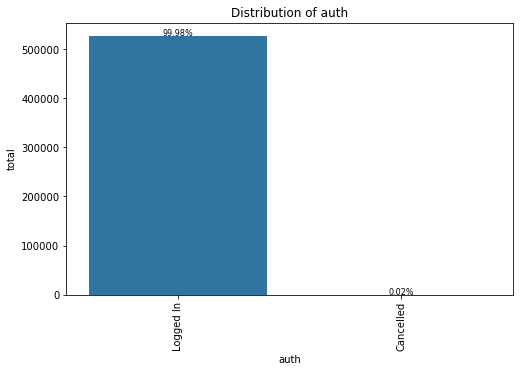

In [16]:
sns_barplot_text('auth', 'total', auth_count, title="Distribution of auth")

### firstName and lastName

* There are 345 distinct first name and 275 distinct last name

In [17]:
customer_event_df.select("firstName").distinct().count()

345

In [18]:
customer_event_df.select("lastName").distinct().count()

275

### itemInSession

* This is the number position of the event in the session
* On averge, the number postition of the event is 107 in one single session.

In [19]:
customer_event_df.select("itemInSession").describe().show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            528005|
|   mean|107.77899451709737|
| stddev|116.86478662969917|
|    min|                 0|
|    max|              1005|
+-------+------------------+



In [20]:
customer_event_df.select("itemInSession").distinct().count()

1006

### length

* Average song length is around 3 minutes and 20 seconds.
* length 0 means that the user did not listen to any songs
* longest song is around 10 mins

In [21]:
customer_event_df.select("length").describe().show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           528005|
|   mean|203.8639462294142|
| stddev|130.6652089637992|
|    min|              0.0|
|    max|       3024.66567|
+-------+-----------------+



### Method 

* GET is used to request data from a specified resource and PUT method is used to send data to a server to.
* This means all the GET method are not listing to songs 

In [22]:
method_count = customer_event_df.select("method").groupby("method"). \
    agg({'method': 'count'}).select('method', col('count(method)').alias('total')). \
    sort(desc('total')).toPandas()

In [23]:
customer_event_df.filter(col("method") == "GET").groupby('artist').agg({'artist': 'count'}).show()

+------+-------------+
|artist|count(artist)|
+------+-------------+
|  None|        38877|
+------+-------------+



In [24]:
customer_event_df.filter(col("method") == "GET").groupby('page').agg({'page': 'count'}).show()

+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|                Home|      19089|
|           Downgrade|       3811|
|         Roll Advert|       7773|
|Cancellation Conf...|         99|
|               About|       1026|
|            Settings|       2964|
|                Help|       2644|
|             Upgrade|        968|
|               Error|        503|
+--------------------+-----------+



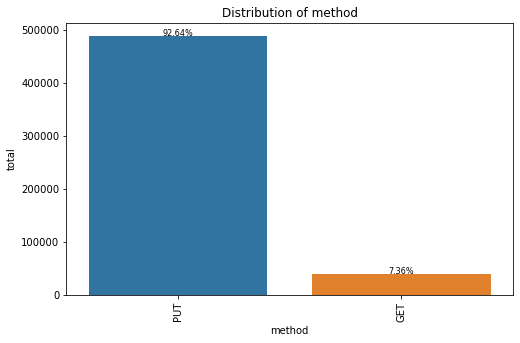

In [25]:
sns_barplot_text("method", "total", method_count, title='Distribution of method')

### registration and ts

* both registration and ts are timestamp features in unix or ns format. We will clean it later.

In [26]:
customer_event_df.select(['userId', 'registration', 'ts']).limit(5).show()

+------+-------------+-------------+
|userId| registration|           ts|
+------+-------------+-------------+
|   293|1532063507000|1538352011000|
|    98|1538069638000|1538352025000|
|   179|1535953455000|1538352118000|
|   179|1535953455000|1538352119000|
|   246|1535931018000|1538352124000|
+------+-------------+-------------+



### userId and sessionid

* These are unqiues id and will be dropped during modelling
* 448 unique userId and 4470 unique sessionId

In [27]:
customer_event_df.select(countDistinct('userId').alias('number_of_userId'), 
                         countDistinct('sessionId').alias('number_of_sessionId')).show()

+----------------+-------------------+
|number_of_userId|number_of_sessionId|
+----------------+-------------------+
|             448|               4470|
+----------------+-------------------+



### song

* The most listened songs are You're The One, Undo and Revelry.
* For users that have None entry, they are on pages such as Thumbs up, Home and Add to Playlist.

In [28]:
song_count = customer_event_df.select("song", 'artist').groupby("song"). \
    agg({'song': 'count'}).select('song', col('count(song)').alias('total')). \
    sort(desc('total')).toPandas()

In [29]:
song_count.head(10)

,song,total
0,None,95128
1,You're The One,2219
2,Undo,1938
3,Revelry,1613
4,Sehr kosmisch,1341
5,Horn Concerto No. 4 in E flat K495: II. Romanc...,1236
6,Dog Days Are Over (Radio Edit),1048
7,Secrets,916
8,Use Somebody,894
9,Canada,836


In [30]:
customer_event_df.filter(col('song') == 'None').groupby('page'). \
    agg({'page': 'count'}).sort((desc('count(page)'))).show()

+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|           Thumbs Up|      23826|
|                Home|      19089|
|     Add to Playlist|      12349|
|          Add Friend|       8087|
|         Roll Advert|       7773|
|              Logout|       5990|
|         Thumbs Down|       4911|
|           Downgrade|       3811|
|            Settings|       2964|
|                Help|       2644|
|               About|       1026|
|             Upgrade|        968|
|       Save Settings|        585|
|               Error|        503|
|      Submit Upgrade|        287|
|    Submit Downgrade|        117|
|              Cancel|         99|
|Cancellation Conf...|         99|
+--------------------+-----------+



### status

* 91.59% of the requested are succeeded with status code 200, 8.31% with status code 307 (redirect) and 0.1% of the requested page is 404 not found.

In [31]:
status_count = customer_event_df.select("status", 'artist').groupby("status"). \
    agg({'status': 'count'}).select('status', col('count(status)').alias('total')). \
    sort(desc('total')).toPandas()

In [32]:
status_count['status'] = status_count['status'].astype('str')

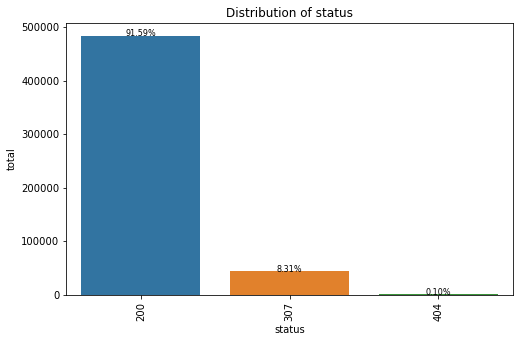

In [33]:
sns_barplot_text('status', 'total', status_count, title="Distribution of status")

### userAgent

* Majority of users using Sparkify app on desktop os
* We extract the device OS, browser OS and browser version from the userAgent information to better capture the relationship of churn

In [34]:
customer_event_df.select("userAgent").distinct().count()

71

In [35]:
useragent_count = customer_event_df.select("userAgent").groupby("userAgent"). \
    agg({'userAgent': 'count'}).select('userAgent', col('count(userAgent)').alias('total')). \
    sort(desc('total')).toPandas()

In [36]:
# useragent_count['percentage'] = useragent_count['total'] / useragent_count['total'].sum() * 100
# useragent_count.head()

In [37]:
def os_feature(s):
    os = re.findall("Ubuntu|Windows|Mac|iPad|iPhone|Linux", s)
    if os:
        os = os[0].translate(str.maketrans('', '', string.punctuation)).strip()
    
    return os

def browser_feature(s):
    browser_list = re.findall("Chrome[/\w+.]+|Safari[/\w.]+|Mobile[/\w.]+|Firefox[/\w.]+|Trident[/\w.]+", s)
    if browser_list:
        browser = browser_list[0].strip().split("/")[0]
    
    return browser

def browser_version_feature(s):
    browser_list = re.findall("Chrome[/\w+.]+|Safari[/\w.]+|Mobile[/\w.]+|Firefox[/\w.]+|Trident[/\w.]+", s)
    if browser_list:
        version = browser_list[0].strip().split("/")[1]
    
    return version

os_udf = udf(os_feature, StringType())
browser_udf = udf(browser_feature, StringType())
version_udf = udf(browser_version_feature, StringType())

In [38]:
customer_event_df = customer_event_df.withColumn("os",
                                                 os_udf(customer_event_df.userAgent))

In [39]:
customer_event_df = customer_event_df.withColumn("browser",
                                                 browser_udf(customer_event_df.userAgent))
customer_event_df = customer_event_df.withColumn("browser_ver",
                                                 version_udf(customer_event_df.userAgent))

In [40]:
customer_event_df.select("browser").groupby("browser"). \
    agg({'browser': 'count'}).select('browser', col('count(browser)').alias('total')). \
    sort(desc('total')).show()

+-------+------+
|browser| total|
+-------+------+
| Chrome|275306|
|Firefox|113562|
| Safari| 70734|
|Trident| 37918|
| Mobile| 30485|
+-------+------+



In [41]:
customer_event_df.select("browser_ver").groupby("browser_ver"). \
    agg({'browser_ver': 'count'}).select('browser_ver', col('count(browser_ver)').alias('total')). \
    sort(desc('total')).show()

+-------------+------+
|  browser_ver| total|
+-------------+------+
|36.0.1985.125|115262|
|36.0.1985.143|102205|
|         31.0| 99914|
| 37.0.2062.94| 43300|
|     537.77.4| 40880|
|       11D257| 24807|
|     537.78.2| 18384|
|          7.0| 16141|
|          6.0| 11070|
|         30.0| 10775|
|          5.0| 10707|
|37.0.2062.103|  7301|
|      600.1.8|  5566|
|35.0.1916.153|  4942|
|       11D201|  3437|
|34.0.1847.116|  2296|
|       11D167|  2241|
|         24.0|  2072|
|      600.1.3|  1800|
|    534.59.10|  1783|
+-------------+------+
only showing top 20 rows



## Define Churn

* There are 99 cancellation of subscription in this tiny dataset.
* We create a `churn` label column for the dataset. It returns 1 if `Cancecllation Confirmation` events happens.


In [42]:
customer_event_df.filter(col("page") == "Cancellation Confirmation" ). \
    select("userId").distinct().count()

99

In [43]:
is_cancellation = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

customer_event_df = customer_event_df.withColumn("churn", is_cancellation("page"))
# there are users that cancelled their subscription in one of the session 
# we have to assign 1 to these users
window_func = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding,
                                                        Window.unboundedFollowing)
customer_event_df = customer_event_df.withColumn("churn", Fsum("churn").over(window_func))

## Further Analysis 

* In this section, we analyze how different features interact with the churn rate.
* We convert the `ts` and `registration` feature into datetime object.
* Extract day and week feature from `ts` to observe the churn rate of weekday and hour.

In [44]:
# ts feature
customer_event_df.select("ts").describe().show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              528005|
|   mean|1.540966927748447E12|
| stddev| 1.481233094025866E9|
|    min|       1538352011000|
|    max|       1543622466000|
+-------+--------------------+



In [45]:
start_ts = int(1538352011000) / 1000
start_date = datetime.utcfromtimestamp(start_ts).strftime("%Y-%m-%d %H:%M:%S")
print(f"Start Time: {start_date}")

end_ts = int(1543622466000) / 1000
end_date = datetime.utcfromtimestamp(end_ts).strftime("%Y-%m-%d %H:%M:%S")
print(f"End Time: {end_date}")

Start Time: 2018-10-01 00:00:11
End Time: 2018-12-01 00:01:06


In [46]:
datetime.fromtimestamp(int(1543622466000) / 1000).month

12

In [47]:
ts_to_day_fn = udf(lambda ts: int(datetime.fromtimestamp(ts / 1000.0).strftime("%w")), IntegerType())
ts_to_hour_fn = udf(lambda ts: datetime.fromtimestamp(ts / 1000.0).hour, IntegerType())
ts_to_date_fn = udf(lambda ts: datetime.fromtimestamp(ts / 1000.0).date(), DateType())
ts_to_month_fn = udf(lambda ts: datetime.fromtimestamp(ts / 1000.0).month, IntegerType())

customer_event_df = customer_event_df.withColumn("event_weekday", 
                                                 ts_to_day_fn(customer_event_df.ts))
customer_event_df = customer_event_df.withColumn("event_hour", 
                                                 ts_to_hour_fn(customer_event_df.ts))
customer_event_df = customer_event_df.withColumn("event_month",
                                                 ts_to_month_fn(customer_event_df.ts))

In [48]:
customer_event_df = customer_event_df.withColumn("event_date",
                                                 ts_to_date_fn(customer_event_df.ts))
customer_event_df = customer_event_df.withColumn("registration_date",
                                                 ts_to_date_fn(customer_event_df.registration))


In [49]:
def clean_location(s):
    
    location = s.split(",")[1].strip()
    
    if len(location) >= 3:
        location = location.split("-")[0].strip()
    return location

clean_location_udf = udf(clean_location, StringType())

customer_event_df = customer_event_df.withColumn("location",
                                                 clean_location_udf(customer_event_df.location))

In [50]:
customer_event_df.printSchema()

root
 |-- artist: string (nullable = false)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = false)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = false)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- os: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- browser_ver: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- event_weekday: integer (nullable = true)
 |-- event_hour: integer (nullable = true)
 |-- event_month: integer (nullable = true)
 |-- event_date: da

In [51]:
# create a temp view from customer_even_df to use SQL type of syntax for data analysis
customer_event_df.createOrReplaceTempView('event');

In [52]:
churn_count_df = spark.sql("""
                           SELECT churn, 
                                  Count(DISTINCT userid) AS total_user 
                           FROM   event 
                           GROUP  BY churn 
                           """).toPandas()

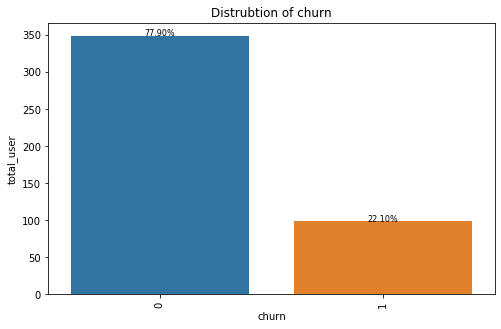

In [53]:
sns_barplot_text(x='churn', y='total_user', data=churn_count_df, title="Distrubtion of churn" )

### Gender and churn rate

* Males user have a slighly more churn rate than female users

In [54]:
gender_count = customer_event_df.select("gender").groupby("gender"). \
    agg({'gender': 'count'}).select('gender', col('count(gender)').alias('total')). \
    sort(desc('total')).toPandas()

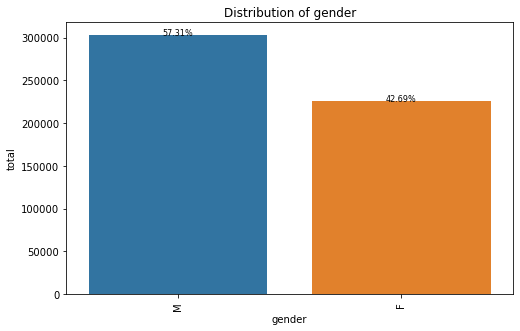

In [55]:
sns_barplot_text('gender', 'total', gender_count, title="Distribution of gender")

In [56]:
gender_churn_df = spark.sql("""
                           SELECT gender, 
                                  churn, 
                           Count(DISTINCT userid) AS total_user 
                           FROM   event 
                           GROUP  BY gender, 
                                     churn  
                           """).toPandas()

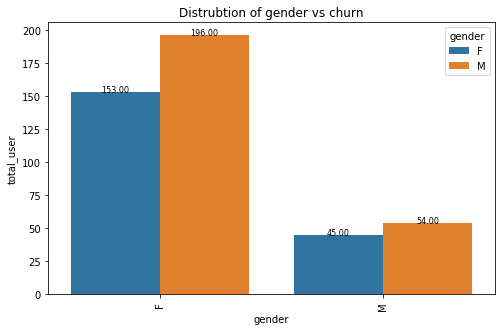

In [57]:
sns_barplot_text('churn', 'total_user', gender_churn_df, hue='gender', 
                 title='Distrubtion of gender vs churn', percentage=False)

### Subscription level and churn rate

* The is the feature that distinguish free user and paid user.
* Around 79.2% of the users are paid user, 20.8% are free users.
* 82 users subscribe for one month and cancel their subscription. This may be "first month trial" offer by Sparkify.

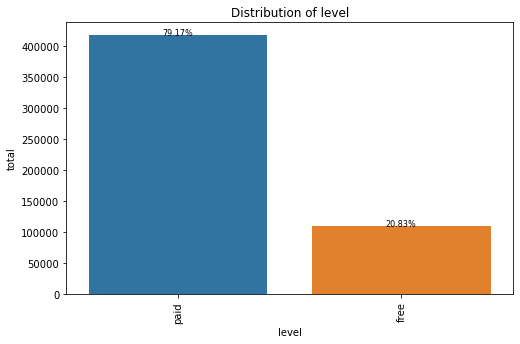

In [58]:
level_count = customer_event_df.select("level").groupby("level"). \
    agg({'level': 'count'}).select('level', col('count(level)').alias('total')). \
    sort(desc('total')).toPandas()

sns_barplot_text('level', 'total', level_count, title="Distribution of level")

In [59]:
level_churn_df = spark.sql("""
                           SELECT level, 
                                  churn, 
                           Count(DISTINCT userid) AS total_user 
                           FROM   event 
                           GROUP  BY level, 
                                     churn  
                           ORDER BY churn
                           """).toPandas()

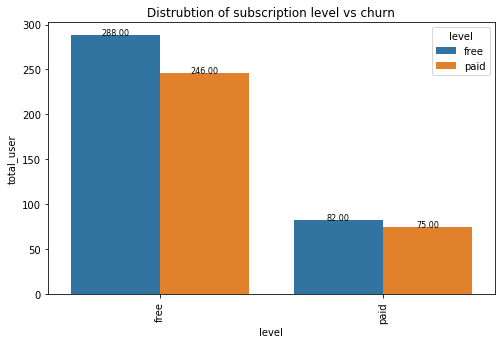

In [60]:
sns_barplot_text('churn', 'total_user', data=level_churn_df, hue='level', 
                 title='Distrubtion of subscription level vs churn', percentage=False)

In [61]:
gender_level_churn_df = spark.sql("""
                                  SELECT level, 
                                         gender,
                                         churn, 
                                  Count(DISTINCT userid) AS total_user 
                                  FROM   event 
                                  GROUP  BY level,
                                            gender,
                                            churn  
                                  ORDER BY churn
                                  """).toPandas()

/anaconda3/envs/ds/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


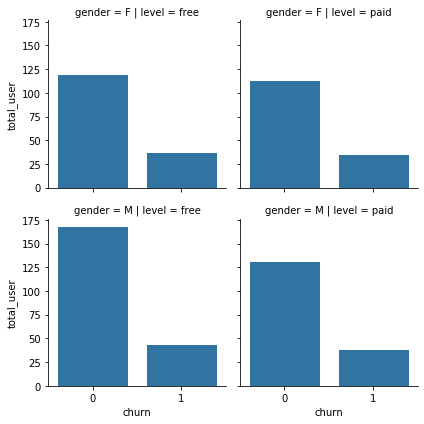

In [62]:
g = sns.FacetGrid(gender_level_churn_df, col="level",  row="gender")
g = g.map(sns.barplot, "churn", "total_user", edgecolor="w")

### location and churn rate

* Most of the users are from New Youk, LA, Boston and Chicago.
* Once we define churn rate, it would  be interesting see the intersection of both features

In [63]:
customer_event_df.select("location").distinct().count()

49

In [64]:
location_count = customer_event_df.select("location").groupby("location"). \
    agg({'location': 'count'}).select('location', col('count(location)').alias('total')). \
    sort(desc('total')).toPandas()

location_count.head(5)

,location,total
0,CA,78171
1,NY,43710
2,TX,42442
3,FL,32129
4,IL,24855


In [65]:
location_df = spark.sql("""
                           SELECT location, 
                                  Count(DISTINCT userid) AS total_user 
                           FROM   event 
                           GROUP  BY location 
                           ORDER BY total_user
                           DESC
                           """).toPandas()

In [66]:
location_churn_df = spark.sql("""
                           SELECT location, 
                                  Count(DISTINCT userid) AS churn_user 
                           FROM   event 
                           WHERE churn=1
                           GROUP BY location
                           """).toPandas()



In [67]:
merge_df = location_churn_df.merge(location_df, on='location').sort_values(by='total_user', ascending=False)

In [68]:
merge_df['percentage'] = merge_df['churn_user'] / merge_df['total_user'] * 100

In [69]:
merge_df.sort_values(by='percentage', ascending=False).head(20)

,location,churn_user,total_user,percentage
14,VT,1,1,100.000000
32,OK,2,3,66.666667
8,KY,4,6,66.666667
24,NM,2,3,66.666667
25,PA,7,17,41.176471
28,GA,6,15,40.000000
2,LA,2,5,40.000000
7,RI,2,5,40.000000
3,NJ,1,3,33.333333
22,OH,4,12,33.333333


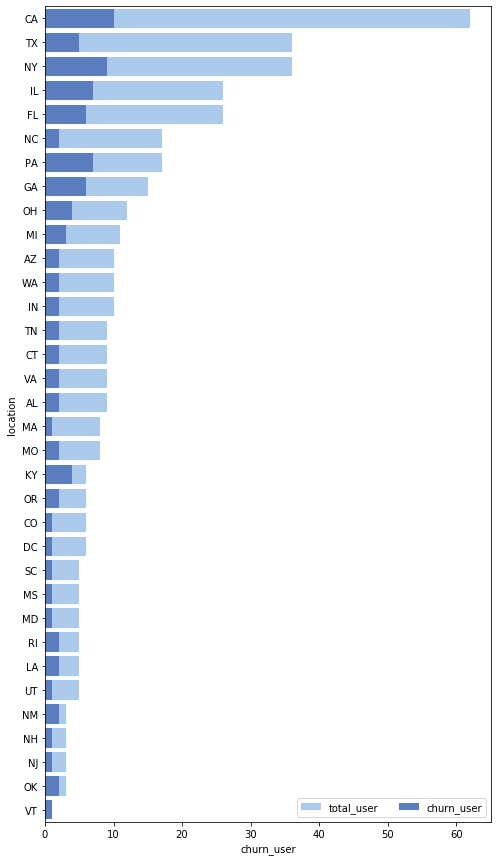

In [70]:
fig, ax = plt.subplots(figsize=(8, 15))
sns.set_color_codes("pastel")
sns.barplot(x='total_user', y='location', data=merge_df, ax=ax,
            label='total_user',color='b')

sns.set_color_codes("muted")
sns.barplot(x='churn_user', y='location', data=merge_df, ax=ax, 
            label='churn_user',color='b')
ax.legend(ncol=2, loc="lower right", frameon=True)

### page insterection 


* Most frequent page is NextSong follows by Thumbs Up
* NextSong account for almost 82% of the pages
* Clearly pages is heavily linked to the churn rate of the user. We will dive deep into 

#### page with level

* More users submit upgrade then users submit downgrades
* As expected, more free users rolls advert


In [71]:
page_count = customer_event_df.select("page").groupby("page"). \
    agg({'page': 'count'}).select('page', col('count(page)').alias('total')). \
    sort(desc('total')).toPandas()

page_count['percentage'] = page_count['total']/ page_count['total'].sum()

page_count

,page,total,percentage
0,NextSong,432877,0.819835
1,Thumbs Up,23826,0.045125
2,Home,19089,0.036153
3,Add to Playlist,12349,0.023388
4,Add Friend,8087,0.015316
5,Roll Advert,7773,0.014721
6,Logout,5990,0.011345
7,Thumbs Down,4911,0.009301
8,Downgrade,3811,0.007218
9,Settings,2964,0.005614


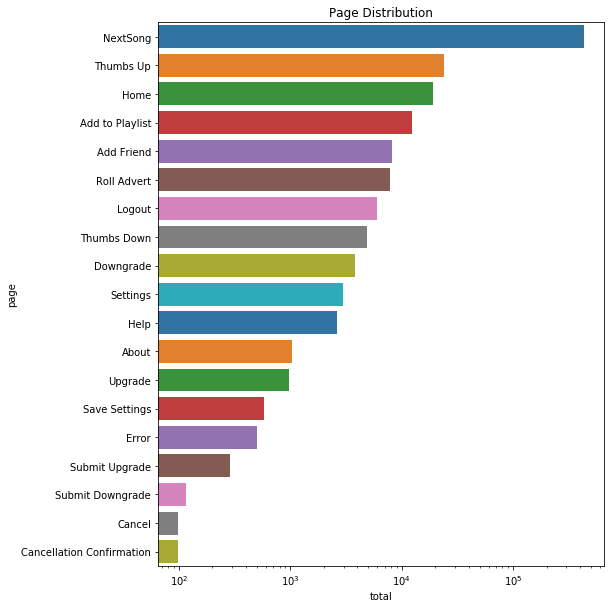

In [72]:
current_palette = sns.color_palette()
fig, ax = plt.subplots(figsize=(8, 10))

sns.barplot(x=page_count['total'],
            y=page_count['page'],
            log=True,
            ax=ax,
            palette=current_palette)
ax.set_title("Page Distribution");


In [73]:
page_gender_df = spark.sql("""
                    SELECT page,
                           gender,
                           COUNT(userId) AS total_visit
                    FROM   event
                    GROUP BY page,
                             gender
                    """).toPandas()

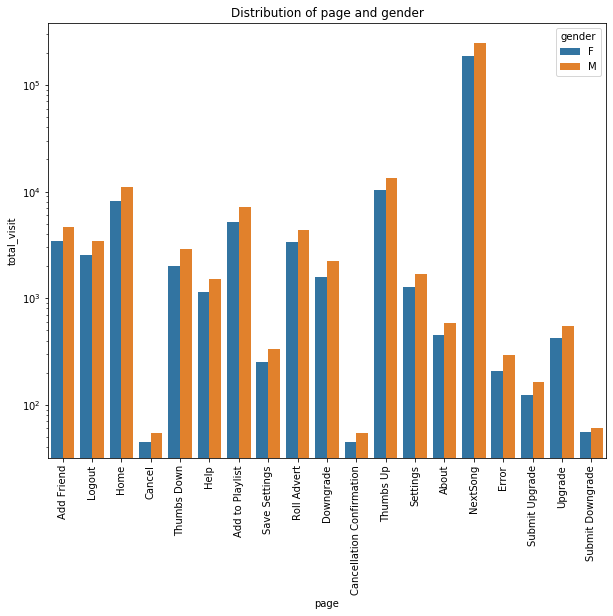

In [74]:
sns_barplot_text(x='page', y='total_visit', data=page_gender_df, hue="gender",
                 title="Distribution of page and gender", percentage=False,
                 text=False, log=True, figsize=(10, 8))

In [75]:
page_churn_df = spark.sql("""
                    SELECT page,
                           churn,
                           COUNT(DISTINCT(userId)) AS total_user
                    FROM   event
                    GROUP BY page,
                             churn
                    """).toPandas()

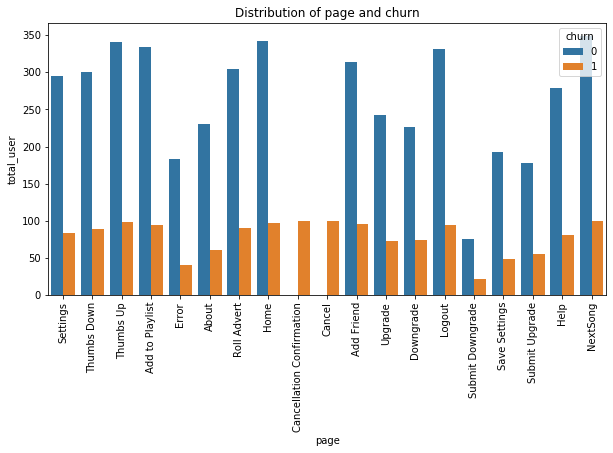

In [76]:
sns_barplot_text(x='page', y='total_user', data=page_churn_df, hue="churn",
                 title="Distribution of page and churn", percentage=False,
                 text=False, figsize=(10, 5))

### Day, hour feature intersection

#### Day of the week page visit churn rate

* less users using Sparkify on Sunday and Saturday resulting less churn
* 

In [77]:
day_user_churn_df = spark.sql("""
                    SELECT event_weekday,
                           churn,
                           COUNT(DISTINCT(userId)) AS total_user
                    FROM   event
                    GROUP BY event_weekday,
                             churn
                    """).toPandas()

In [78]:
day_user_churn_df = day_user_churn_df.sort_values(by="event_weekday")

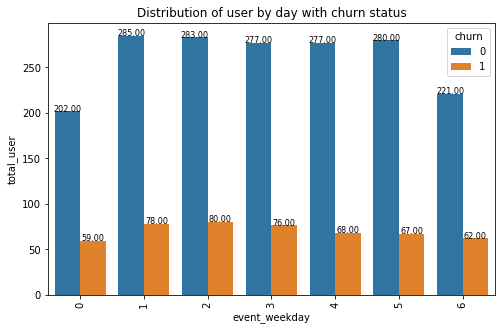

In [79]:
sns_barplot_text(x='event_weekday', y='total_user', data=day_user_churn_df, hue="churn",
                 title="Distribution of user by day with churn status", percentage=False,
                 text=True)

In [80]:
day_event_churn_df = spark.sql("""
                    SELECT event_weekday,
                           churn,
                           COUNT(userId) AS total_event
                    FROM   event
                    GROUP BY event_weekday,
                             churn
                    ORDER BY event_weekday
                    """).toPandas()

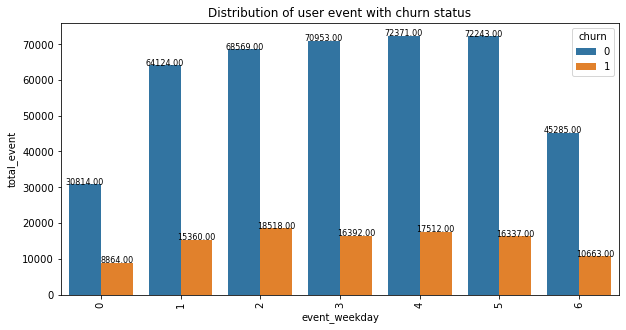

In [81]:
sns_barplot_text(x='event_weekday', y='total_event', data=day_event_churn_df, hue="churn",
                 title="Distribution of user event with churn status", percentage=False,
                 text=True, figsize=(10, 5))

In [82]:
hour_user_churn_df = spark.sql("""
                    SELECT event_hour,
                           churn,
                           COUNT(DISTINCT(userId)) AS total_user
                    FROM   event
                    GROUP BY event_hour,
                             churn
                    ORDER BY event_hour
                    """).toPandas()

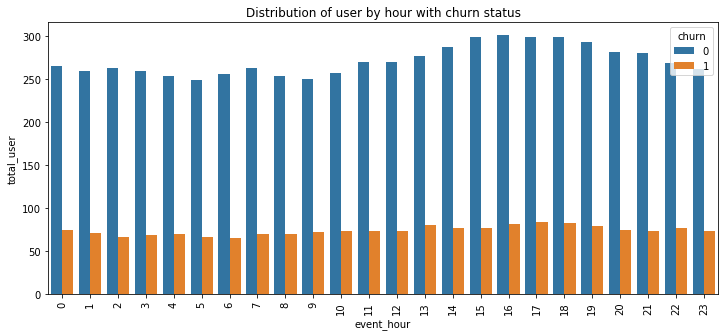

In [83]:
sns_barplot_text(x='event_hour', y='total_user', data=hour_user_churn_df, hue="churn",
                 title="Distribution of user by hour with churn status", percentage=False,
                 text=False, figsize=(12,5))

In [84]:
hour_event_churn_df = spark.sql("""
                    SELECT event_hour,
                           churn,
                           COUNT(userId) AS total_event
                    FROM   event
                    GROUP BY event_hour,
                             churn
                    ORDER BY event_hour
                    """).toPandas()

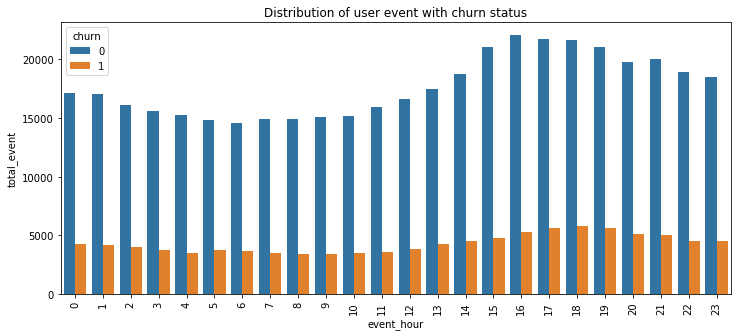

In [85]:
sns_barplot_text(x='event_hour', y='total_event', data=hour_event_churn_df, hue="churn",
                 title="Distribution of user event with churn status", percentage=False,
                 text=False, figsize=(12,5))

In [86]:
daily_counts_df = spark.sql("""
                            SELECT event_date,
                                   churn,
                                   COUNT(userId) AS total_event
                            FROM   event
                            GROUP BY event_date,
                                     churn
                            ORDER BY event_date
                            """).toPandas()

/anaconda3/envs/ds/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


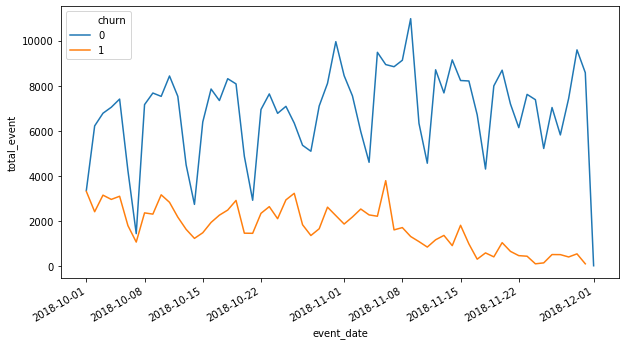

In [87]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x="event_date",
             y='total_event',
             hue='churn',
             data=daily_counts_df,
             ax=ax)
plt.xticks(rotation=30, ha="right");


In [88]:
daily_user_counts_df = spark.sql("""
                                 SELECT event_date,
                                        churn,
                                        COUNT(DISTINCT(userId)) AS total_user
                                 FROM   event
                                 GROUP BY event_date,
                                          churn
                                 ORDER BY event_date
                                """).toPandas()

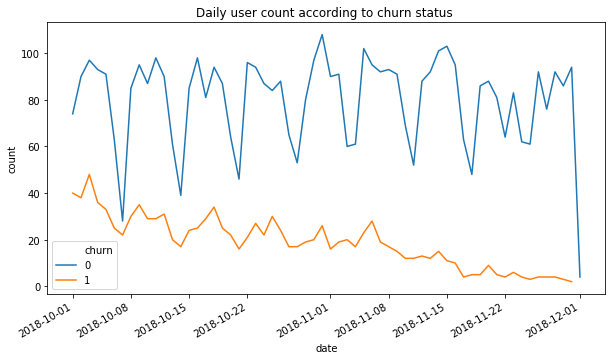

In [89]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x="event_date",
             y='total_user',
             hue='churn',
             data=daily_user_counts_df,
             ax=ax)
ax.set_title("Daily user count according to churn status ")
ax.set_xlabel("date")
ax.set_ylabel("count")
plt.xticks(rotation=30, ha="right");

In [90]:
customer_event_df.printSchema()

root
 |-- artist: string (nullable = false)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = false)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = false)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- os: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- browser_ver: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- event_weekday: integer (nullable = true)
 |-- event_hour: integer (nullable = true)
 |-- event_month: integer (nullable = true)
 |-- event_date: da

### useragent related features

#### browser

* 40% of mobile browser users has churn. 26% of Firefox user churn


In [91]:
browser_churn_df = spark.sql("""
                            SELECT browser,
                                   churn,
                                   COUNT(DISTINCT(userId)) AS total_user
                            FROM   event
                            GROUP BY browser,
                                     churn
                            ORDER BY browser
                            """).toPandas()

In [92]:
browser_churn_df.groupby("browser")['total_user'].sum()

browser
Chrome     229
Firefox     99
Mobile      27
Safari      62
Trident     31
Name: total_user, dtype: int64

In [93]:
browser_churn_df.loc[browser_churn_df.churn==1, 'total_user'] / browser_churn_df.groupby("browser")['total_user'].sum().values * 100

0    19.213974
2    26.262626
4    40.740741
7    17.741935
9    22.580645
Name: total_user, dtype: float64

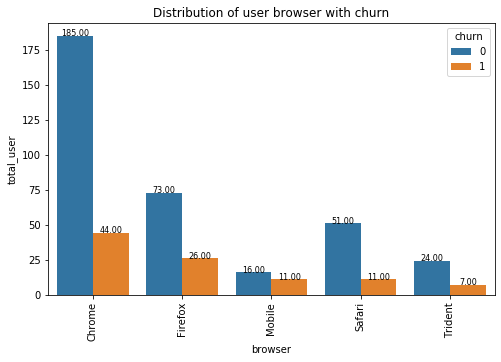

In [94]:
sns_barplot_text(x='browser', y='total_user', data=browser_churn_df, hue='churn',
                 title="Distribution of user browser with churn", percentage=False,
                 text=True)


#### os

* 61% of iphone os users has churned, no ipad users churn

In [95]:
os_churn_df = spark.sql("""
                        SELECT os,
                               churn,
                               COUNT(DISTINCT(userId)) AS total_user
                        FROM   event
                        GROUP BY os,
                                 churn
                        ORDER BY os
                        """).toPandas()


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


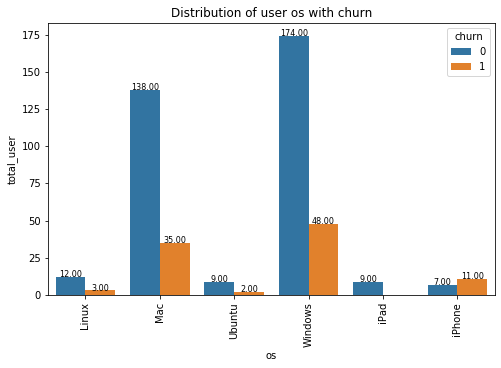

In [96]:
sns_barplot_text(x='os', y='total_user', data=os_churn_df, hue='churn',
                 title="Distribution of user os with churn", percentage=False,
                 text=True)

In [97]:
os_level_df = spark.sql("""
                        SELECT os,
                               level,
                               COUNT(DISTINCT(userId)) AS total_user
                        FROM   event
                        GROUP BY os,
                                 level
                        ORDER BY os
                        """).toPandas()

# Feature Engineering


## total number of artist listened

* count the number of aritst each userid listened

In [98]:
count_artist = customer_event_df \
    .filter(col("page") == "NextSong") \
    .select("userId", "artist") \
    .dropDuplicates() \
    .groupby("userId") \
    .count() \
    .withColumnRenamed('count', 'total_artist') \

count_artist.show(5)

+------+------------+
|userId|total_artist|
+------+------------+
|200002|         287|
|100010|          94|
|   296|         108|
|   125|          61|
|   124|        1240|
+------+------------+
only showing top 5 rows



## Binarise gender, level

In [99]:
binarize_gender = customer_event_df \
    .select("userId", "gender") \
    .dropDuplicates() \
    .replace(["M", "F"], ["0", "1"], "gender") \
    .select("userId", col("gender").cast("int"))

binarize_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|   234|     0|
|   188|     1|
|    44|     1|
|   273|     0|
|    46|     1|
+------+------+
only showing top 5 rows



In [100]:
binarize_level = customer_event_df \
    .select("userId", "level") \
    .dropDuplicates() \
    .replace(["free", "paid"], ["0", "1"], 'level') \
    .select("userId", col("level").cast("int"))

binarize_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|    94|    1|
|100021|    0|
|100029|    0|
|    18|    0|
|200050|    1|
+------+-----+
only showing top 5 rows



## Page features

### downgrades page

In [101]:
downgrade_feat = customer_event_df \
    .select("userId", "page") \
    .where(col("page") == "Downgrade") \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "num_downgrade")

downgrade_feat.show(5)

+------+-------------+
|userId|num_downgrade|
+------+-------------+
|   296|            1|
|200002|            3|
|    51|            4|
|   124|           21|
|   205|           10|
+------+-------------+
only showing top 5 rows



### Roll Advert page

In [102]:
advert_feat = customer_event_df \
    .select("userId", "page") \
    .where(col("page") == "Roll Advert") \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "num_advert")

advert_feat.show(5)

+------+----------+
|userId|num_advert|
+------+----------+
|   296|         9|
|100010|        22|
|200002|        11|
|   125|         6|
|     7|        35|
+------+----------+
only showing top 5 rows



### add to playlist

In [103]:
playlist_feat = customer_event_df \
    .select("userId", "page") \
    .where(col("page") == "Add to Playlist") \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "num_song_playlist")

playlist_feat.show(5)

+------+-----------------+
|userId|num_song_playlist|
+------+-----------------+
|   296|                3|
|100010|                1|
|200002|                6|
|   125|                2|
|    51|                8|
+------+-----------------+
only showing top 5 rows



### thumbs down and thumbs up

In [104]:
thumbs_down_feat = customer_event_df \
    .select("userId", "page") \
    .where(col("page") == "Thumbs Down") \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "num_thumbs_down")

thumbs_down_feat.show(5)

+------+---------------+
|userId|num_thumbs_down|
+------+---------------+
|100010|              3|
|200002|              5|
|   125|              1|
|   124|             15|
|    51|              1|
+------+---------------+
only showing top 5 rows



In [105]:
thumbs_up_feat = customer_event_df \
    .select("userId", "page") \
    .where(col("page") == "Thumbs Up") \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "num_thumbs_up")

thumbs_down_feat.show(5)

+------+---------------+
|userId|num_thumbs_down|
+------+---------------+
|100010|              3|
|200002|              5|
|   125|              1|
|   124|             15|
|    51|              1|
+------+---------------+
only showing top 5 rows



### Add Friend

In [106]:
friend_feat = customer_event_df \
    .select("userId", "page") \
    .where(col("page") == "Add Friend") \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "num_friend")

friend_feat.show(5)

+------+----------+
|userId|num_friend|
+------+----------+
|   296|         2|
|100010|         3|
|200002|         2|
|   125|         3|
|   124|        26|
+------+----------+
only showing top 5 rows



## total length of time listened

In [ ]:
total_length = customer_event_df \
    .select("userId", "length") \
    .groupby("userId") \
    .sum() \
    .withColumnRenamed("sum(length)", 'total_length')
    
total_length.show(5)

## Number of songs listened 


In [ ]:
total_songs = customer_event_df \
    .select("userId", "song") \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "num_song") 

total_songs.show(5)

## Number of sessions per user


In [ ]:
num_session = customer_event_df \
    .select("userId", "sessionId") \
    .dropDuplicates() \
    .groupby("userId") \
    .count() \
    .withColumnRenamed('count', 'session') 

num_session.show()

## average songs per session

In [ ]:
avg_songs_session = customer_event_df.filter(col("page") == "NextSong") \
    .groupby("userId", "sessionId") \
    .count() \
    .groupby("userId") \
    .agg({"count": "avg"}) \
    .withColumnRenamed("avg(count)", "avg_songs") 
    

avg_songs_session.show(5)

## average session per day/month


In [ ]:
daily_sess = customer_event_df.groupby(['userId', 'event_weekday']).agg(countDistinct('sessionId')) \
    .groupby('userId').avg('count(DISTINCT sessionId)') \
    .withColumnRenamed('avg(count(DISTINCT sessionId))', 'avg_daily_sessions')

In [ ]:
month_sess = customer_event_df.groupby(['userId', 'event_month']).agg(countDistinct('sessionId')) \
    .groupby('userId').avg('count(DISTINCT sessionId)') \
    .withColumnRenamed('avg(count(DISTINCT sessionId))', 'avg_monthly_sessions')
month_sess.show(5)

## location feature

In [ ]:
location_feat = customer_event_df \
    .select("userId", "location") \
    .dropDuplicates()

##  os and browser features

In [ ]:
os_feat = customer_event_df \
    .select("userId", "os") \
    .dropDuplicates()

In [ ]:
browser_feat = customer_event_df \
    .select("userId", "browser") \
    .dropDuplicates()

In [ ]:
browser_ver_feat = customer_event_df \
    .select("userId", "browser_ver") \
    .dropDuplicates()

In [ ]:
label = customer_event_df \
    .select('userId', col('churn').alias('label')) \
    .dropDuplicates() \
    .orderBy("userId")

label.describe().show()

In [ ]:
transformed_event = count_artist.join(binarize_gender, "userId", "outer") \
    .join(binarize_level, "userId", "outer") \
    .join(downgrade_feat, "userId", "outer") \
    .join(advert_feat, "userId", "outer") \
    .join(playlist_feat, "userId", "outer") \
    .join(thumbs_down_feat, "userId", "outer") \
    .join(thumbs_up_feat, "userId", "outer") \
    .join(friend_feat, "userId", "outer") \
    .join(total_length, "userId", "outer") \
    .join(total_songs, "userId", "outer") \
    .join(num_session, "userId", "outer") \
    .join(avg_songs_session, "userId", "outer") \
    .join(daily_sess, "userId", "outer") \
    .join(month_sess, "userId", "outer") \
    .join(location_feat, "userId", "outer") \
    .join(os_feat, "userId", "outer") \
    .join(browser_feat, "userId", "outer") \
    .join(browser_ver_feat, "userId", "outer") \
    .join(label, "userId", "outer") \
    .drop("userId") \
    .fillna(0)

In [ ]:
# dataset_pd = transformed_event.toPandas()
# dataset_pd.to_csv("../data/preprocessed_dataset.csv")

# Modeling


In [ ]:
# customer_df = spark.read.csv("../data/preprocessed_dataset.csv", header=True)
# customer_df = customer_df.drop("_c0")

In [ ]:
dataset.head()

In [ ]:
customer_df.printSchema()

In [ ]:
cat_cols = ["location", "os", "browser", "browser_ver"]
num_cols= ["total_artist", "gender", "level", "num_downgrade", "num_advert", "num_song_playlist",
           "num_thumbs_down", "num_thumbs_up", "num_friend", "total_length", "num_song",
           "session", "avg_songs", "avg_daily_sessions", "avg_monthly_sessions"]

In [ ]:
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_index") for c in cat_cols]

encoders = [StringIndexer(inputCol=indexer.getOutputCol(), 
                          outputCol=f"{indexer.getOutputCol()}_encoded")
            for indexer in indexers]
assemblerCat = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders],
                               outputCol="cat")
pipelineCat = Pipeline(stages=indexers+encoders+[assemblerCat])
customer_df = pipelineCat.fit(customer_df).transform(customer_df)

In [ ]:
assemblerNum = VectorAssembler(inputCols=num_cols, outputCol="num")
pipelineNum = Pipeline(stages=[assemblerNum])
customer_df = pipelineNum.fit(customer_df).transform(customer_df)

In [ ]:
del indexers, encoders, assemblerCat, pipelineCat

In [ ]:
del customer_df

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.